<h1> Customer Segmentation and Clustering </h1>
<hr>
<h3>In the last part of this demonstration, we are going to divide our cutomers into key groups with clustering. A process called customer segmentation. We can use the extracted information for further analysis and future business strategy planning (like seasonal discounts, special offers, etc.) or we can assign new customers to a cluster based on their behavior.</h3>
<br><br>
After importing the libraries and the dataset that we are going to use in this section, we prepare the data for clustering. Our customers either belong to UK (which comprises the majority of them), or to a foreign country. So we divide them to UK and non-UK customers. The next step is to group the data by the customers and choose a way to aggregate the values over them.

In [23]:
#importing necessary libraries and the dataset
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib inline

CleanDataset = r'../Cleaned-Dataset/OnlineRetail_Cleaned.csv'
Data_Cleaned = pd.read_csv(CleanDataset, index_col = 'InvoiceDate')
Data_Cleaned.index = pd.to_datetime(Data_Cleaned.index, format = '%Y-%m-%d %H:%M', box = False)

In [2]:
#grouping the data by customers and preparing for segmentation
Data = Data_Cleaned.copy()
Data['Country'] = Data['Country'].map(lambda x: 'UK' if x=='UNITED KINGDOM' else 'non-UK')
CustomerData = Data.groupby(['CustomerID','Country'], sort=False).agg({'Quantity':'mean','UnitPrice':'mean','InvoiceNo':'nunique','Description':'nunique'})
CustomerData.reset_index(inplace=True)
CustomerData.columns = ['CustomerID', 'UK?', 'Average Quantity', 'Average Price', 'Repeats', 'Product Variety']
CustomerData.head()

,CustomerID,UK?,Average Quantity,Average Price,Repeats,Product Variety
0,17850.0,UK,5.513158,3.740428,35,24
1,13047.0,UK,6.984536,4.016289,16,105
2,12583.0,non-UK,21.182979,2.182894,17,116
3,13748.0,UK,15.678571,4.053571,5,24
4,15100.0,UK,9.666667,12.750000,6,1


Before we begin the process, it would be a good idea to scale the numerical features in order to avoid the negative effects of feature magnitudes and also speed up the process.

In the customer data, we have a categorical variable which is the customer's country. That is the reason we chose an algorithm called k-prototypes which can also take into account the categorical variables. In these types of methods we need to give the algorithm the exact number of clusters. Since we are not sure of the number, we will check the clustering cost and the silhouette score to determine the optimal number of clusters. The average silhouette value determines how similar the data points are to their own cluster compared with the other clusters (using Euclidean distance as default).

In [3]:
#scaling the numerical features for clustering
Scaler = StandardScaler()
CustomerData.iloc[:,2:] = Scaler.fit_transform(CustomerData.iloc[:,2:])
syms = CustomerData.iloc[:,0].values.astype(str)
X = CustomerData.iloc[:,1:].values.astype(object)
#finding the optimal cluster_number k
for n in range(2,8):
    kproto = KPrototypes(n_clusters = n, init = 'Cao')
    clusters = kproto.fit_predict(X, categorical = [0])
    silhouette = silhouette_score(X[:,1:],clusters)
    print('number of clusters:', n)
    print('  cost: ',kproto.cost_)
    print('  average silhouette score: ',silhouette)

number of clusters: 2
  cost:  14380.190053147258
  average silhouette score:  0.5520788140635531
number of clusters: 3
  cost:  11500.545820780453
  average silhouette score:  0.5696948143298892
number of clusters: 4
  cost:  9077.882288488257
  average silhouette score:  0.4034366559033268
number of clusters: 5
  cost:  6847.605756305624
  average silhouette score:  0.41269382224718854
number of clusters: 6
  cost:  6043.243893489291
  average silhouette score:  0.35011262629146706
number of clusters: 7
  cost:  5301.95492095881
  average silhouette score:  0.33034270527035037


It seems that three clusters could properly represent our data, so we implement the algorithm with k = 3.

In [6]:
#clustering with kprototypes with k = 3
kproto = KPrototypes(n_clusters = 3, init = 'Cao')
clusters = kproto.fit_predict(X, categorical = [0])
print('Cluster Centers:\n', kproto.cluster_centroids_)

Cluster Centers:
 [array([[ 8.62114967, -0.88401437,  0.01130489, -0.6524409 ],
       [-0.06351093, -0.17422923,  1.90721994,  2.23757511],
       [-0.0770486 ,  0.02347077, -0.16440776, -0.18651333]]), array([['UK'],
       ['UK'],
       ['UK']], dtype='<U2')]


Since we scaled the data for clustering, we need to scale them back to their actual values and then we put all the original data and their cluster labels in a dataframe.

In [7]:
#scaling back to original values and retrieving all attributes
Clustered = pd.DataFrame(data=Scaler.inverse_transform(CustomerData.iloc[:,2:]),columns=['Average Quantity', 'Average Price', 'Repeats', 'Product Variety'])
Clustered['UK?'] = X[:,0]
Clustered['CustomerID'] = syms
Clustered['Cluster'] = clusters
print(Clustered.groupby(['Cluster','UK?']).count()['Repeats'],'\n\n\n')
print(Clustered.groupby(['Cluster','UK?']).mean())

Cluster  UK?   
0        UK          35
         non-UK       3
1        UK         307
         non-UK      35
2        UK        3588
         non-UK     382
Name: Repeats, dtype: int64 



                Average Quantity  Average Price    Repeats  Product Variety
Cluster UK?                                                                
0       UK            369.849336       1.852343   5.400000         5.600000
        non-UK        387.809524       1.488571   1.333333         3.666667
1       UK             13.389770       2.827273  21.850163       249.263844
        non-UK         17.782164       2.855736  25.771429       292.485714
2       UK             13.127527       3.116832   3.499443        45.214047
        non-UK         14.734203       3.051530   3.374346        47.858639


Now we can see how our clusters are distributed along each variable in pairwise scatterplots. In the first cluster there are customers (mostly from UK) who bought very specific products with low prices in large volumes but not very often, one-time customers are more likely to be in this segment. The second cluster represents our regular customers who visit quite often buying various products in small quantities. The third cluster consists of customers who bought different products with higher price and they occasionally make a purchase, the majority of our customers (both from UK and non-UK countries) are within this cluster.

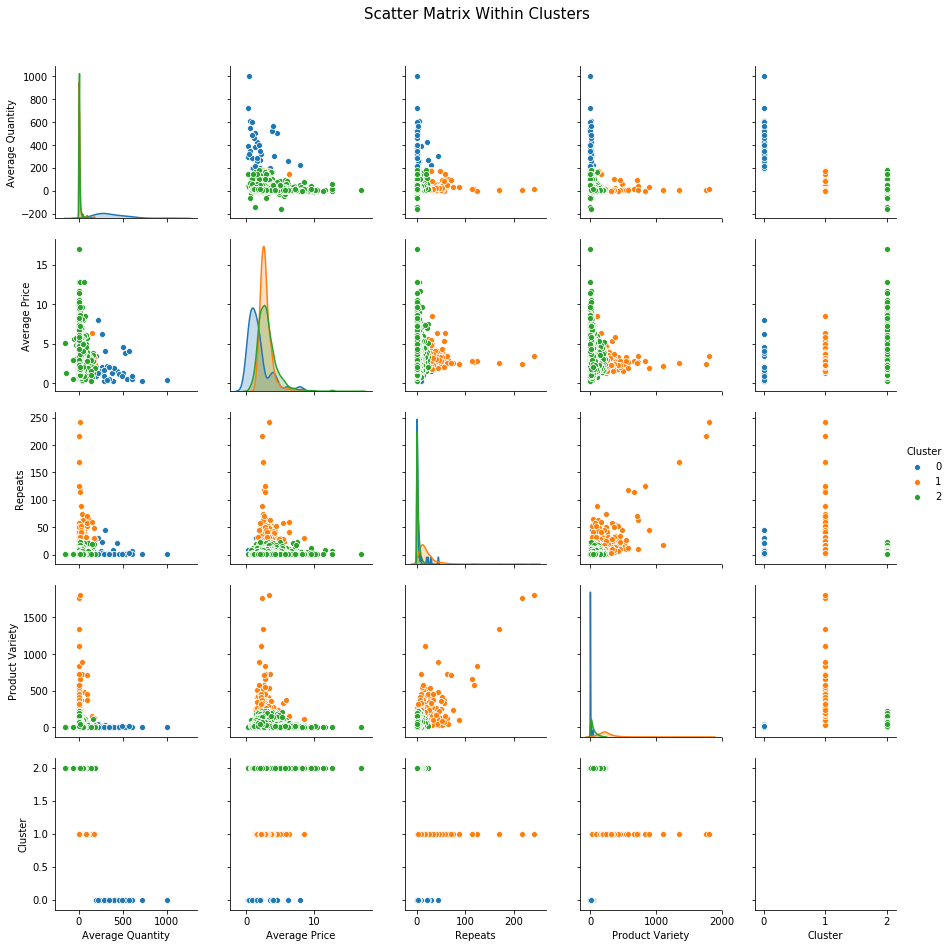

In [20]:
#comparison plots
sns.pairplot(Clustered.drop(columns=['UK?','CustomerID']), hue='Cluster')
plt.suptitle('Scatter Matrix Within Clusters', fontsize = 15, y = 1.05)
plt.show()

In the last part, we will visualize all the datapoints and the cluster which they belong to in one plot so we can see how they are located in the data space and how well they are seperated and have a good vision of the clusters(customer segments). Each axis shows the corresponding feature, the colors show the cluster which the datapoint belongs to, the size of each point indicates the purchase regularity (repeats) and the markers represent the customer's country (circles for UK and squares for non-UK customers).

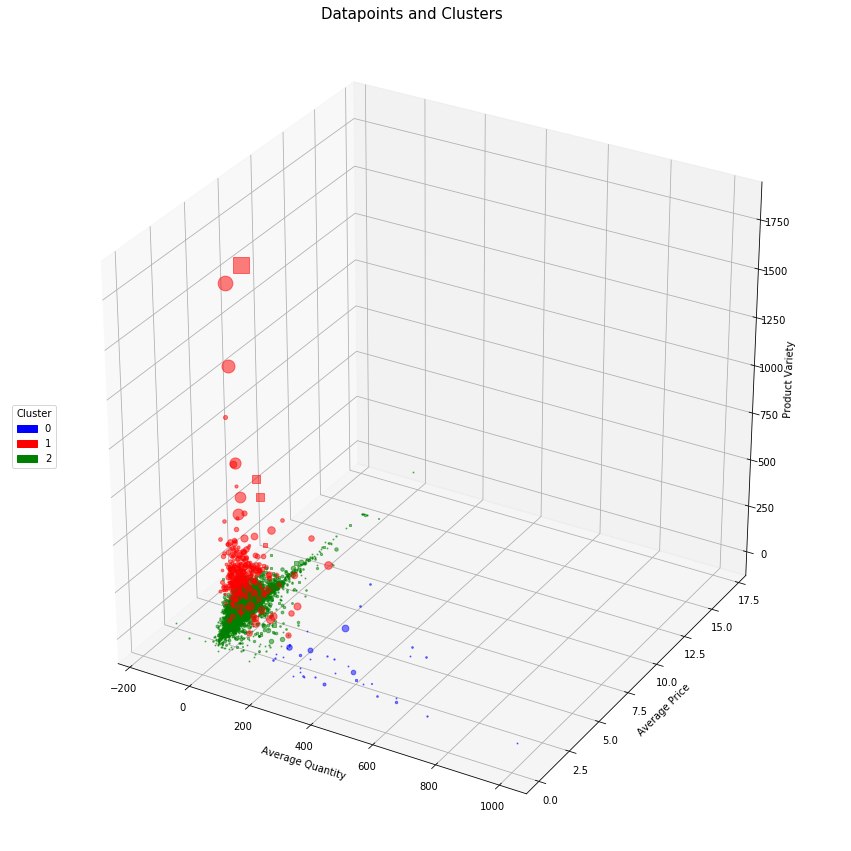

In [24]:
#plotting all datapoints with respect to their cluster
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
#datapoints
xd = list(Clustered['Average Quantity'])
yd = list(Clustered['Average Price'])
zd = list(Clustered['Product Variety'])
data_points = [(x,y,z) for x,y,z in zip(xd,yd,zd)]
#specifying point sizes for the number of repeats
sizes = list(Clustered['Repeats'])
#colors for clusters
colorlist = ['blue','red','green']
colors = list(map(lambda x: colorlist[x], Clustered['Cluster']))
#markers for country names
markers = ['o' if con == 'UK' else ',' for con in list(Clustered['UK?'])]
#creating the scatterplot
for data, size, color, mark in zip(data_points, sizes, colors, markers):
    x,y,z = data
    ax.scatter(x,y,z, alpha=0.5, c=color, s=size, marker=mark)
ax.set(xlabel='Average Quantity', ylabel='Average Price', zlabel='Product Variety')
#plot legend for cluster colors
legend_items = {'0':'blue', '1':'red', '2':'green'}
itemlist = []
for itemkey in legend_items:
    patch = mpatches.Patch(color=legend_items[itemkey], label=itemkey)
    itemlist.append(patch)
plt.legend(handles=itemlist, title='Cluster', fancybox=True, loc=6)
plt.suptitle('Datapoints and Clusters', fontsize = 15, y = 0.90)
plt.show()